In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import numpy as np
import pandas as pd
import os

import scanpy as sc
from anndata import AnnData, concat
from matplotlib.transforms import Bbox

# from scvi.model.utils import mde


from matplotlib import pyplot as plt
import seaborn as sns

from scipy import sparse
import gc
# from upsetplot import plot as UpSet
from itertools import product
import networkx as nx

from scipy.cluster import hierarchy

import re
import subprocess

import h5py

import itertools

# from scnym.api import scnym_api

# import pymn

from collections import Counter

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
out_dir = "/home/anna/ClusterProjects/SA_bone_marrow/scfiles/"

# HSC population

### Reading the unannotated loom file

In [5]:
hvg_subset_HSC_annot = sc.read_h5ad(filename = out_dir + "hvg_HSC_X_scVI_based_200924.h5ad")

In [6]:
hvg_subset_HSC_annot.obsm

AxisArrays with keys: X_mde, X_pca, X_scVI, X_tsne, X_umap, _scvi_extra_categorical_covs, _scvi_extra_continuous_covs, counts_pca, scVI_norm_pca

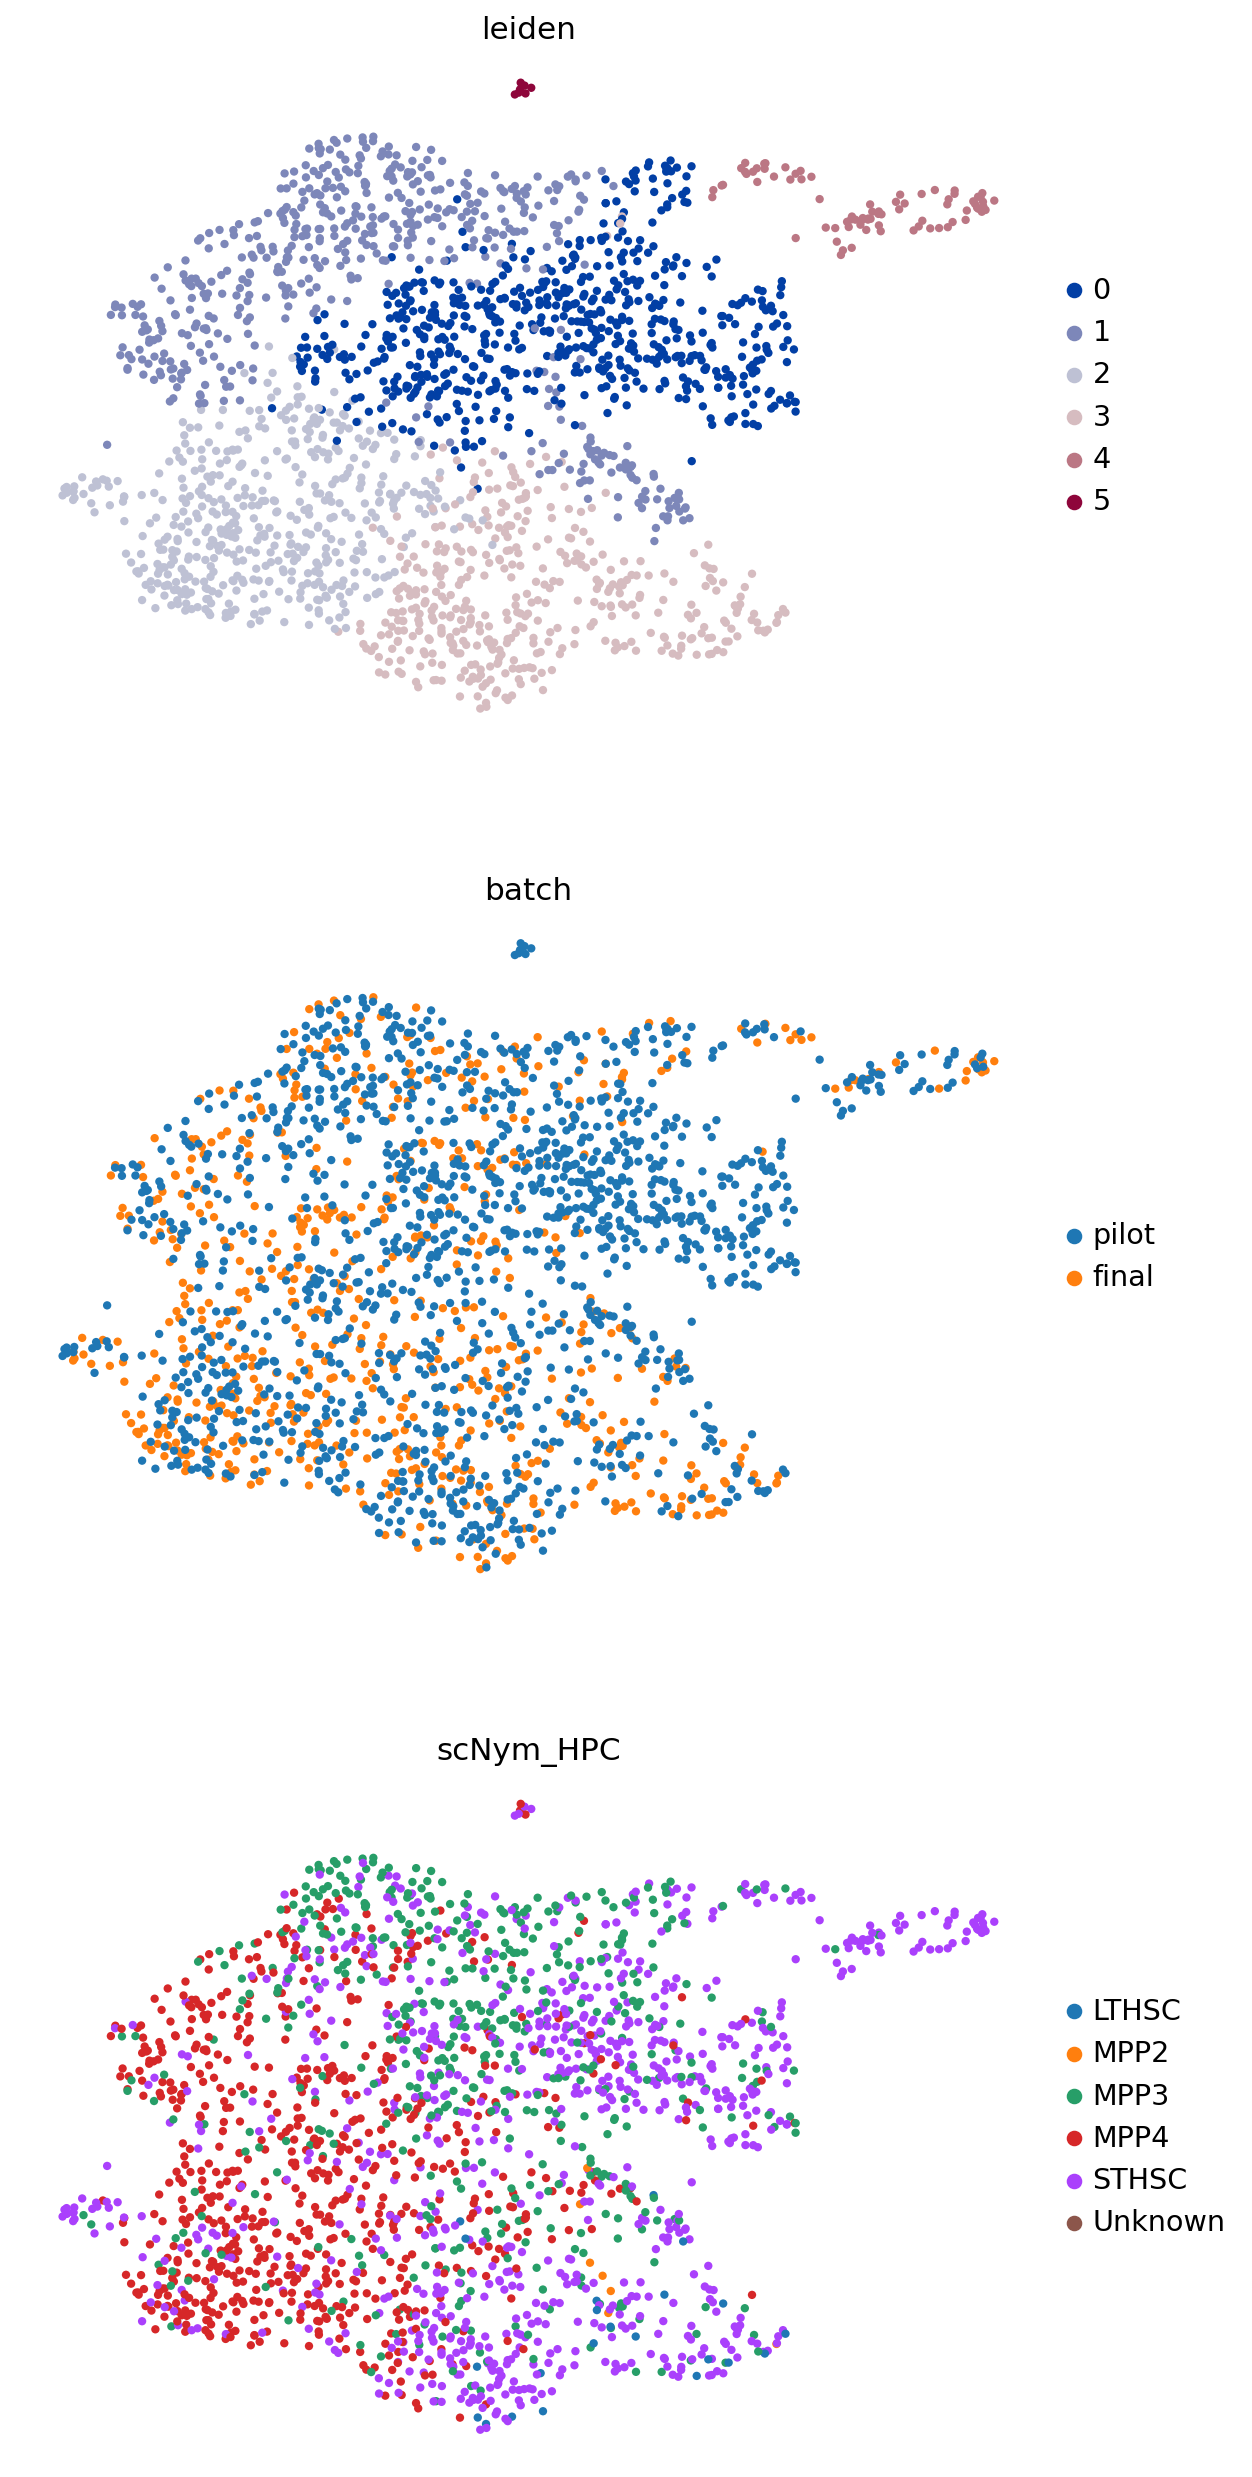

In [7]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_HSC_annot,
    basis="umap",
    color=['leiden', 'batch', "scNym_HPC"],
    frameon=False,
    ncols=1
)

In [7]:
manual_cell_mapping = {"0":"GMP CMP",
               "1": "Proliferating GMP",
               "2": "CLP",
               "3": "Erythroid megakaryocyte progenitor",
               "4": "Granulocyte progenitor",
               "5": "B cell progenitor"}
hvg_subset_HSC_annot.obs["manual_cell_mapping"] = hvg_subset_HSC_annot.obs["leiden"].map(manual_cell_mapping)

In [9]:
hvg_subset_HSC_annot.write_loom(filename = out_dir + "hvg_HSC_X_scVI_based_annotated_220924.loom")
hvg_subset_HSC_annot.write_h5ad(filename = out_dir + "hvg_HSC_X_scVI_based_annotated_220924.h5ad")

The loom file will lack these fields:
{'X_mde', 'PCs', '_scvi_extra_continuous_covs', '_scvi_extra_categorical_covs', 'scVI_norm_pca', 'X_umap', 'X_pca', 'X_scVI', 'counts_pca', 'X_tsne'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [8]:
hvg_subset_HSC_annot = sc.read_h5ad (filename = out_dir + "hvg_HSC_X_scVI_based_annotated_220924.h5ad")

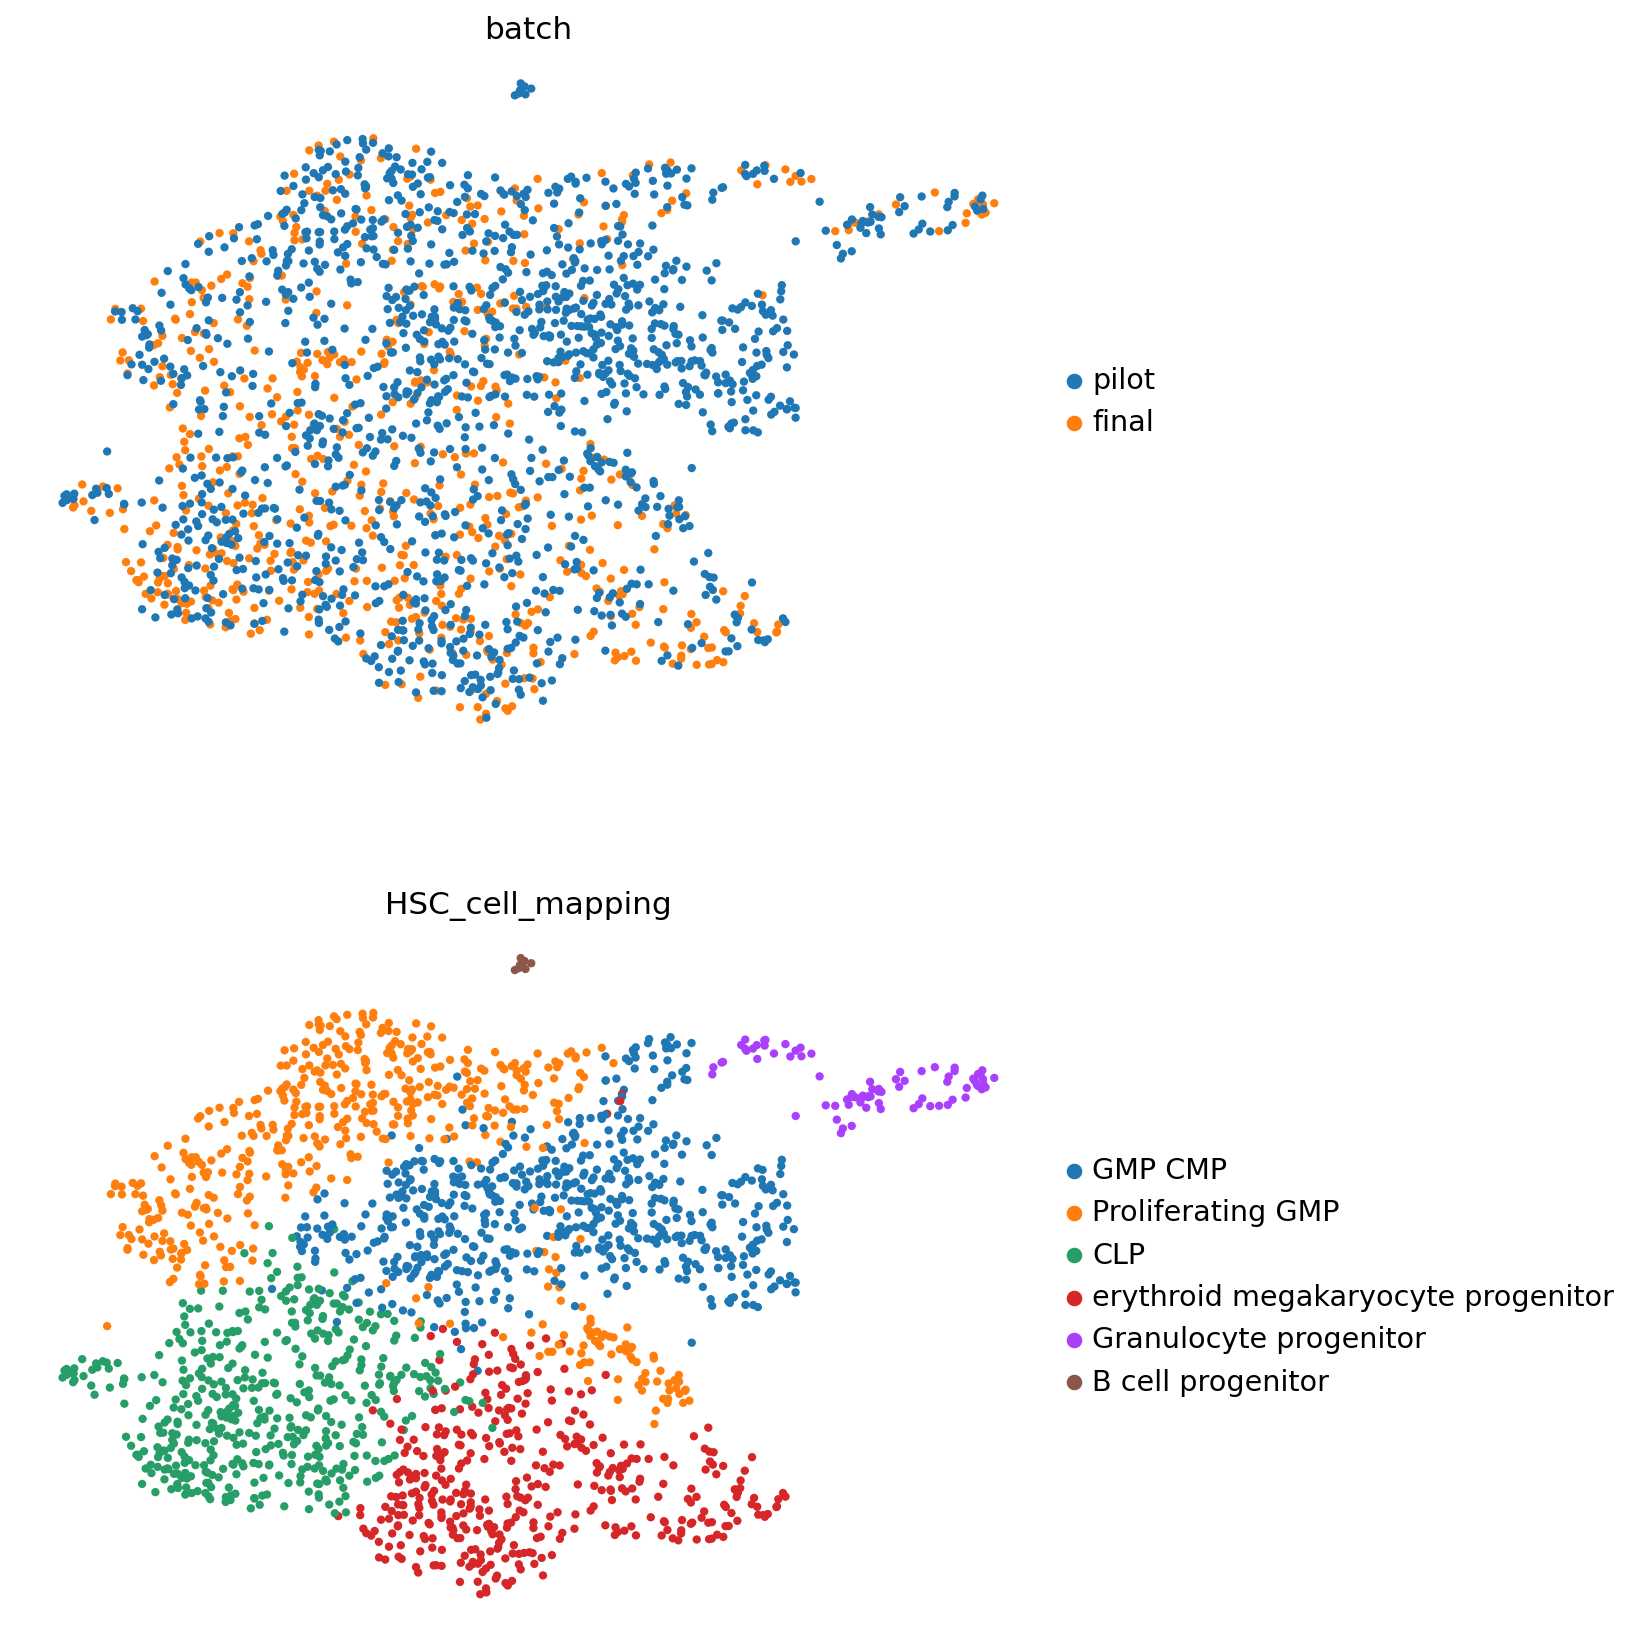

In [46]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_HSC_annot,
    basis="umap",
    color=['batch', "manual_cell_mapping"],
    frameon=False,
    ncols=1,
    save = "HSC_x_scvi_manual_annotation_22092024.pdf"
)

In [10]:
import os

In [17]:
import pandas as pd

# Read the Excel file
file_path = "/home/anna/ClusterProjects/SA_bone_marrow/annotated_clusters/Signature genes _ HSC cluster annotation .xlsx"
excel_data = pd.ExcelFile(file_path)

# Initialize an empty dictionary
HSC_signature_genes = {}

# Loop through each sheet and store values of the "name" column in the dictionary
for sheet_name in excel_data.sheet_names:
    # Read each sheet into a DataFrame
    df = pd.read_excel(excel_data, sheet_name=sheet_name)
    
    # Check if the "name" column exists
    if 'name' in df.columns:
        # Add the values of the "name" column to the dictionary
        filtered_df = df[df['pvalue'] <= 0.05]
        HSC_signature_genes[sheet_name] = filtered_df['name'].tolist()

# Print the resulting dictionary
print(HSC_signature_genes)

{'GMP CMP (cl 0)': ['Elane', 'Mpo', 'Ctsg', 'Prtn3', 'Hbb-bs', 'Hspa5', 'Ly6c2', 'Mif', 'Retnlg', 'Ccr2'], 'proliferating GMPs (cl 1)': ['Hist1h1b', 'Hist1h2ae', 'Hist1h2ap', 'Hist1h4d', 'Top2a', 'Hist1h1e', 'Hist2h2ac', 'Mki67', 'Hist1h1a', 'Hist1h3c', 'Ly6c2', 'Prtn3', 'Ctsg', 'Hist1h3e', 'Mif', 'Cst3'], 'CLPs (cl 2)': ['Ly6d', 'Il7r', 'Notch1', 'Sox4', 'Tcf4', 'Ighm', 'Ebf1', 'Marcks', 'Rag1', 'Tcf7', 'Rag2', 'Vpreb3'], 'Eythroid megakar prog (cl3)': ['Pf4', 'Angpt1', 'Gata2', 'Meis1', 'Pbx1', 'Kit', 'Itga2b', 'Gata1', 'Klf1'], 'granulocyte prog (cl4)': ['S100a9', 'S100a8', 'Camp', 'Ngp', 'Lyz2', 'Prdx5', 'Cebpe', 'Cd177', 'C3', 'Ncf4', 'Pygl', 'Itgam'], 'B cell prog (cl 5)': ['Igkc', 'Igha', 'Jchain', 'Retnlg', 'Ly6a', 'Wfdc17', 'Cd74']}


In [18]:
sc.pp.normalize_total(hvg_subset_HSC_annot, target_sum=1e6)
sc.pp.log1p(hvg_subset_HSC_annot)

# Calculate z-scores across cells for each gene
hvg_subset_HSC_annot.layers['z_scores'] = (hvg_subset_HSC_annot.X - np.mean(hvg_subset_HSC_annot.X, axis=0)) / np.std(hvg_subset_HSC_annot.X, axis=0)

In [ ]:
# sc.set_figure_params(figsize = (8,6))
# for key in HSC_signature_genes.keys():
#     print (key)
#     sc.pl.embedding(
#         hvg_subset_HSC_annot,
#         basis="umap",
#         layer='z_scores',
#         color=HSC_signature_genes[key],
#         frameon=False,
#         # ncols=1,
#         save = "HSC_X_scvi_cluster_signature_genes_" + key + ".pdf"
#     )

# Mature population

In [19]:
hvg_subset_mature_annot = sc.read_h5ad(filename = out_dir + "hvg_mature_X_scVI_based_200924.h5ad")

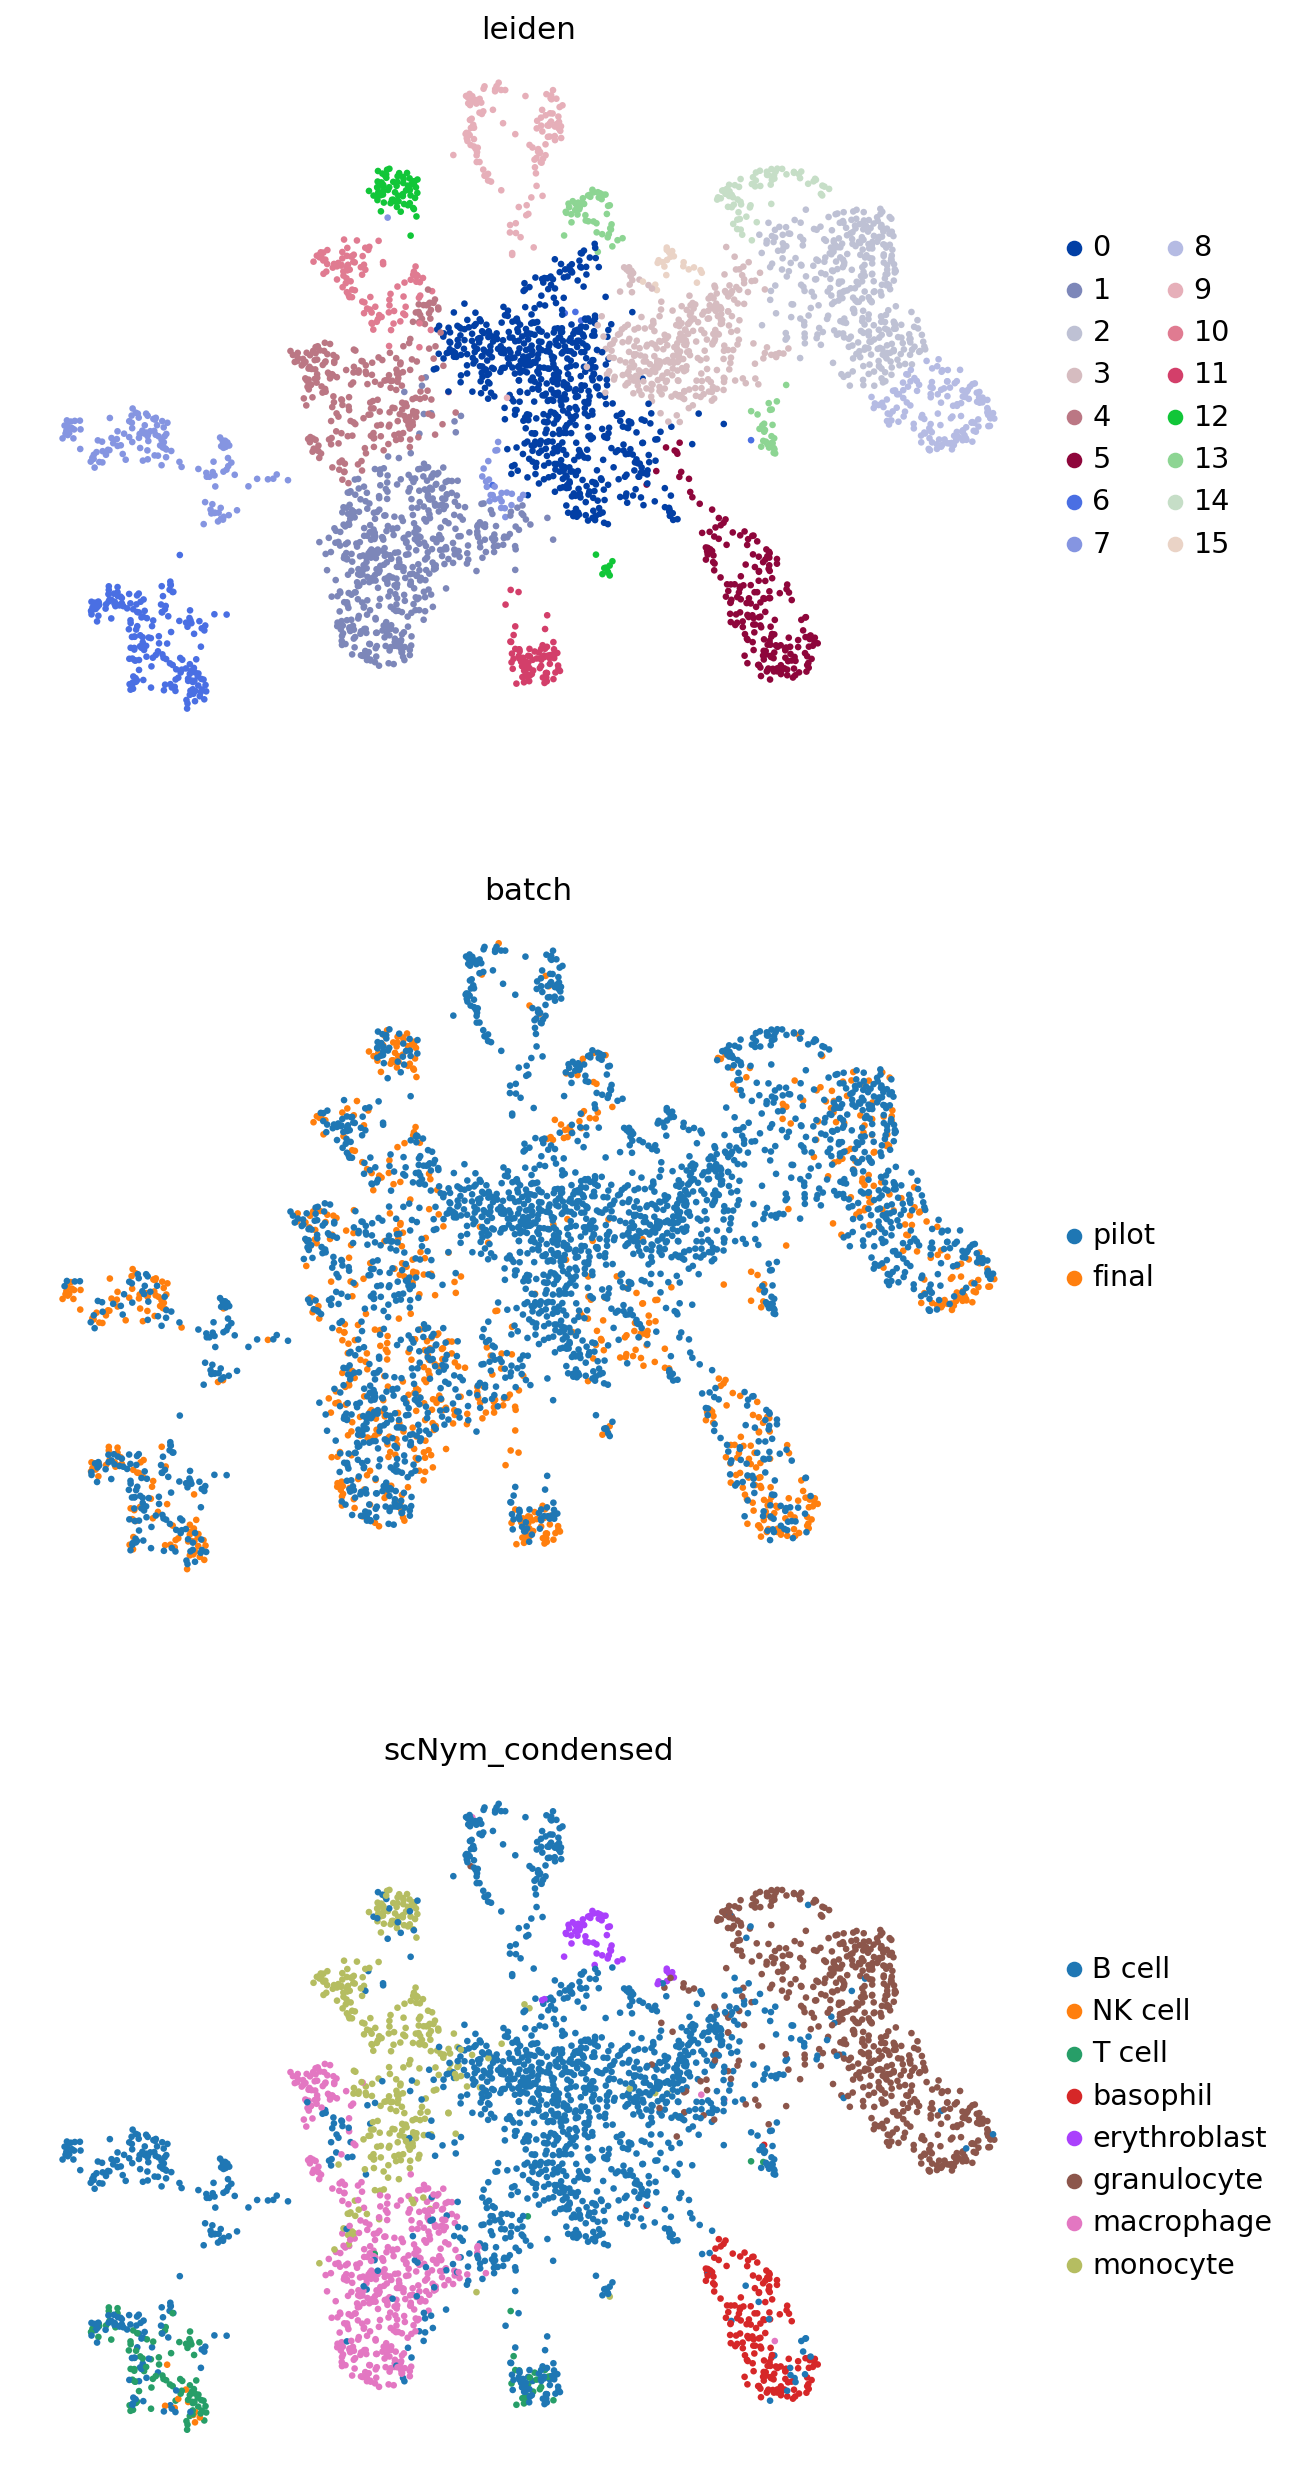

In [20]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_mature_annot,
    basis="umap",
    color=['leiden', 'batch', "scNym_condensed"],
    frameon=False,
    ncols=1
)

In [35]:
manual_cell_mapping = {"0": "Early granulocyte",
               "1": "Dendritic cell",
               "2": "Neutrophil",
               "3": "Granulocyte",
               "4": "Activated DC and macrophage",
               "5": "MC basophil",
               "6": "Cytotoxic T and NK cells",
                   "7" : "Pro B cell",
                   "8": "Neutrophil",
                   "9": "B cell",
                   "10": "Activated monocyte",
                   "11": "Th2 CD4+ T cell",
                   "12": "Activated macrophage",
                   "13":"Erythroblast",
                   "14":"Neutrophil",
                   "15":"Other"}
hvg_subset_mature_annot.obs["manual_cell_mapping"] = hvg_subset_mature_annot.obs["leiden"].map(manual_cell_mapping)

In [36]:
hvg_subset_mature_annot.write_loom(filename = out_dir + "hvg_mature_X_scVI_based_annotated_220924.loom")
hvg_subset_mature_annot.write_h5ad(filename = out_dir + "hvg_mature_X_scVI_based_annotated_220924.h5ad")

The loom file will lack these fields:
{'X_mde', 'PCs', '_scvi_extra_continuous_covs', '_scvi_extra_categorical_covs', 'scVI_norm_pca', 'X_umap', 'X_pca', 'X_scVI', 'counts_pca', 'X_tsne'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [11]:
hvg_subset_mature_annot = sc.read_h5ad(filename = out_dir + "hvg_mature_X_scVI_based_annotated_220924.h5ad")

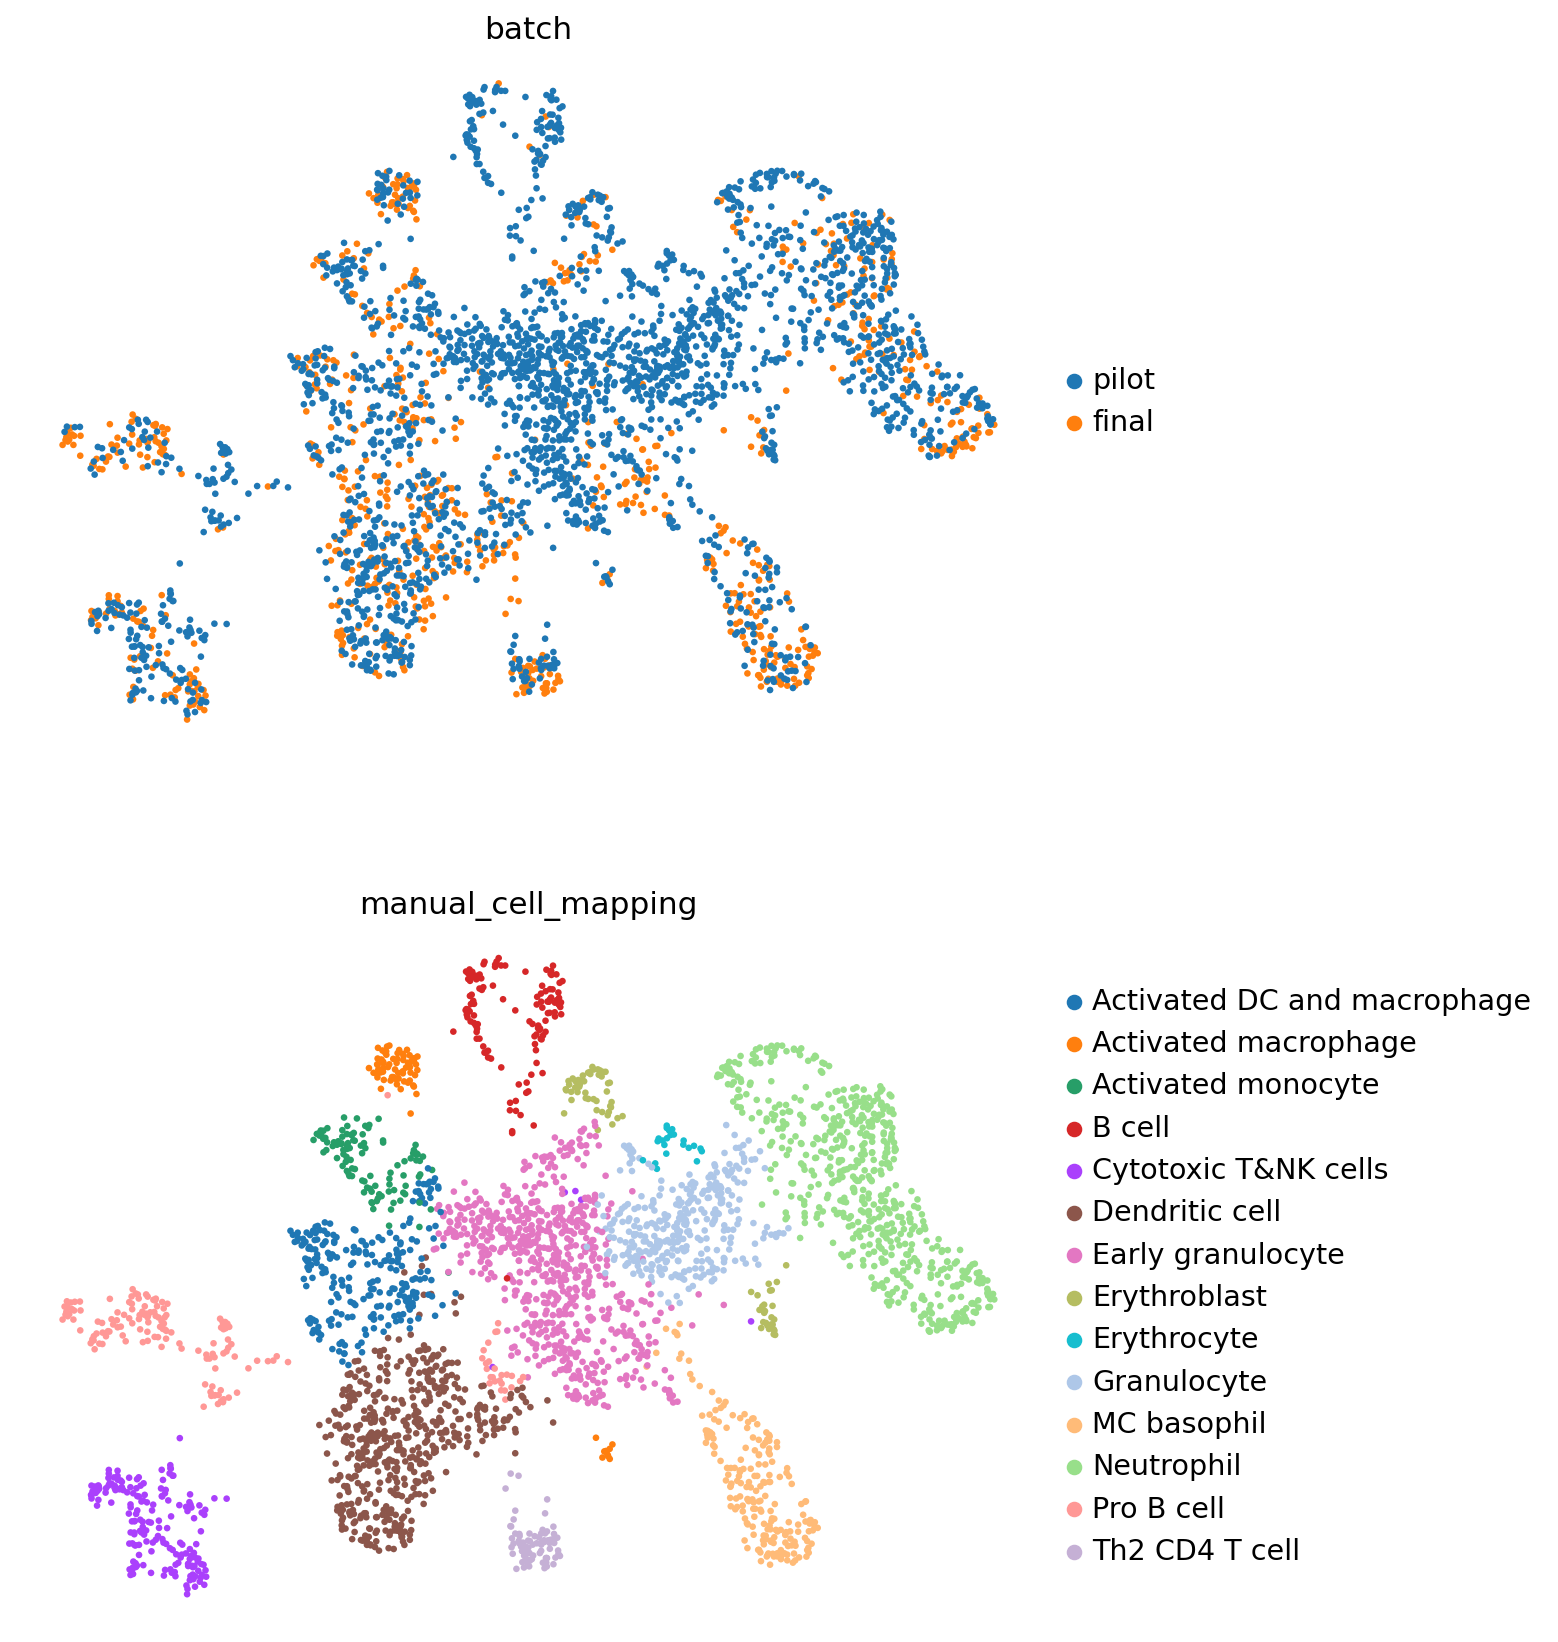

In [122]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_mature_annot,
    basis="umap",
    color=['batch', "manual_cell_mapping"],
    frameon=False,
    ncols=1,
    save = "mature_x_scvi_manual_annotation_22092024.pdf"
)

In [37]:
# Read the Excel file
file_path = "/home/anna/ClusterProjects/SA_bone_marrow/annotated_clusters/Signature genes _ mature cluster annotation.xlsx"
excel_data = pd.ExcelFile(file_path)

# Initialize an empty dictionary
mature_signature_genes = {}

# Loop through each sheet and store values of the "name" column in the dictionary
for sheet_name in excel_data.sheet_names:
    # Read each sheet into a DataFrame
    df = pd.read_excel(excel_data, sheet_name=sheet_name)
    
    # Check if the "name" column exists
    if 'name' in df.columns:
        # Add the values of the "name" column to the dictionary
        filtered_df = df[df['pvalue'] <= 0.05]
        mature_signature_genes[sheet_name] = filtered_df['name'].tolist()

# Print the resulting dictionary
print(mature_signature_genes)

{'Early granulocyte (cluster 0)': ['Mpo', 'Prtn3', 'Elane', 'Prg2', 'Ctsg', 'Cd34', 'Kit'], 'Dendritic cells (Cluster 1)': ['Ly6d', 'Irf8', 'Bst2', 'Tcf4', 'Cox6a2', 'Siglech', 'Runx2', 'Mpeg1', 'Cd7', 'Ccr9'], 'Neutrophil (cluster 2)': ['Ngp', 'Ltf', 'Camp', 'Lcn2', 'S100a9', 'S100a8', 'Pglyrp1', 'Anxa1', 'Lyz2', 'S100a6', 'Hp', 'Cd177', 'Retnlg', 'Lrg1', 'Mmp9', 'Mmp8', 'Itgam', 'Ly6g'], 'Granulocyte (Cluster 3)': ['Elane', 'Prtn3', 'Mpo', 'Ms4a3'], 'Activated DC and macroph (cl 4)': ['Cst3', 'Cd74', 'Hist1h1b', 'H2-Ab1', 'H2-Aa', 'Hist1h2ae', 'Top2a', 'Irf8', 'Mki67', 'H2afx', 'Hist1h4d', 'S100a4', 'Vim', 'Ly6d', 'Ly6d', 'S100a10', 'Hist1h1e', 'Ccr2'], 'MC Basophil (cl 5)': ['Prss34', 'Mcpt8', 'Cpa3', 'Gata2', 'Fcer1a', 'Cd63', 'Ms4a2', 'Ccl3', 'Srgn', 'Cd200r3', 'Ccl9', 'Ccl4'], 'Cytotoxic T & NK cells (cl6)': ['Ccl5', 'Gzma', 'Nkg7', 'Trbc2', 'Il2rb', 'Trbc1', 'Klrb1c', 'Cd3g', 'Tcf7', 'Prf1', 'Klra4', 'Thy1', 'Klre1', 'Xcl1', 'Cd3e'], 'Pro B cells (cl7)': ['Vpreb3', 'Cd79a', 'Ebf

In [38]:
sc.pp.normalize_total(hvg_subset_mature_annot, target_sum=1e6)
sc.pp.log1p(hvg_subset_mature_annot)

# Calculate z-scores across cells for each gene
hvg_subset_mature_annot.layers['z_scores'] = (hvg_subset_mature_annot.X - np.mean(hvg_subset_mature_annot.X, axis=0)) / np.std(hvg_subset_mature_annot.X, axis=0)

In [ ]:
# sc.set_figure_params(figsize = (8,6))
# for key in mature_signature_genes.keys():
#     print (key)
#     sc.pl.embedding(
#         hvg_subset_mature_annot,
#         basis="umap",
#         layer='z_scores',
#         color=mature_signature_genes[key],
#         frameon=False,
#         # ncols=1,
#         save = "mature_X_scvi_cluster_signature_genes_" + key + ".pdf"
#     )

In [64]:
combined_mature_signature_genes = sum(mature_signature_genes.values(), [])
len(combined_mature_signature_genes)

193

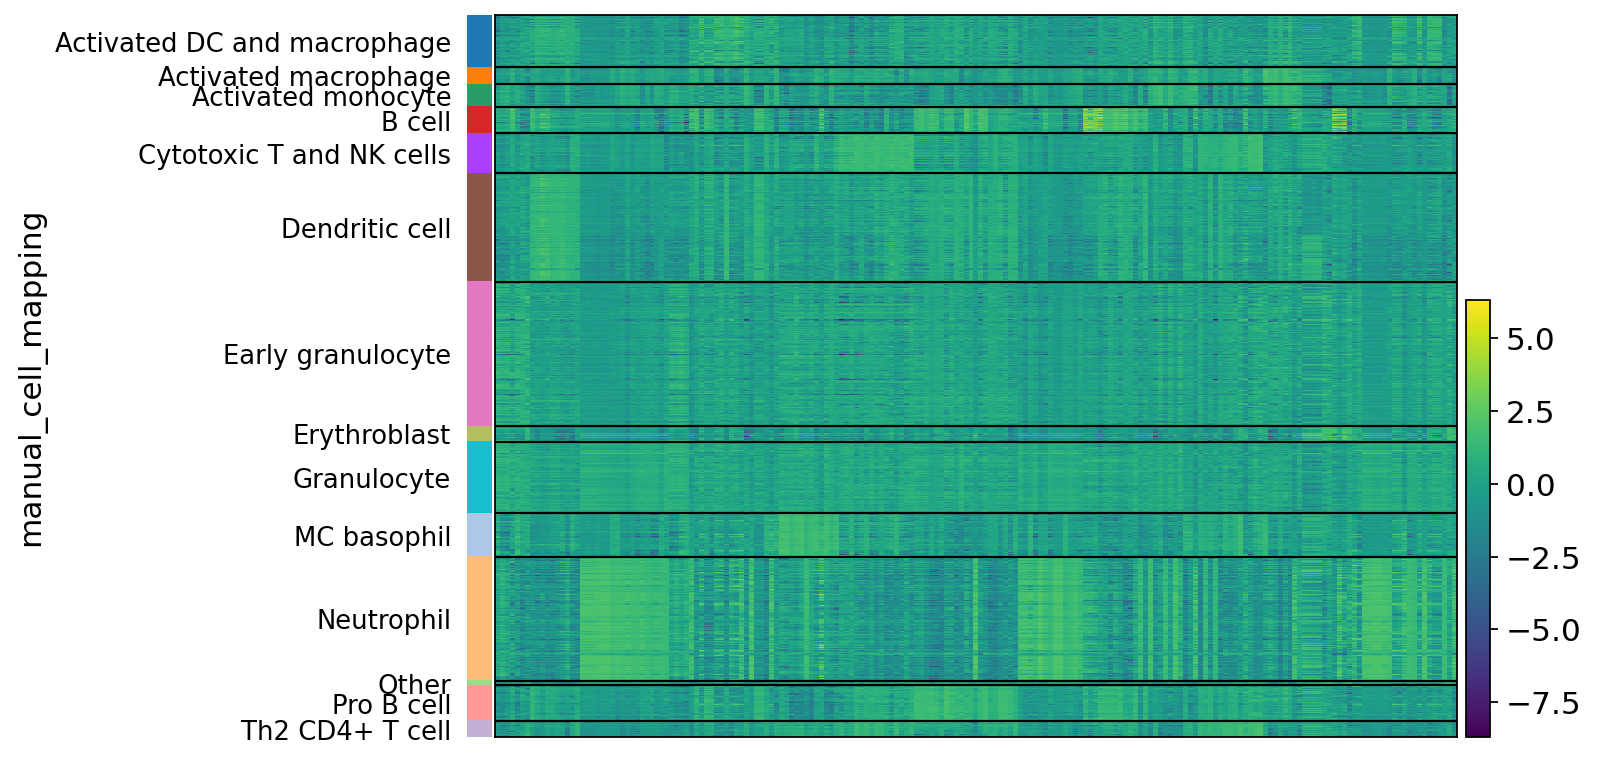

In [68]:
sc.pl.heatmap(hvg_subset_mature_annot, combined_mature_signature_genes, groupby='manual_cell_mapping', layer='z_scores',
             save = "mature_X_scvi_cluster_signature_genes_heatmap.pdf")

### Plotting all the cells

In [14]:
# import os
# os.chdir("python")

In [15]:
### Directory TM_combined_datasets_SA_ann_obs
combined_datasets = sc.read_h5ad(filename = "../data/h5ad/TM_combined_datasets_SA_ann.h5ad")
obs_plk = pd.read_pickle("../data/h5ad/TM_combined_datasets_SA_ann_obs.plk")
combined_datasets.obs = obs_plk

hvg = sc.read("../data/h5ad/hvg_integrated_170824.h5ad")
SA_exps = combined_datasets[combined_datasets.obs["study_id"].isin(['SA_pilot', 'SA_final'])]

del(combined_datasets)

hvg_cells = hvg.obs_names
SA_exp_names = SA_exps.obs_names

SA_hvg_cells = [x for x in SA_exp_names if x[:-2] in hvg_cells]


SA_cellname_counts = Counter([x[:-2] for x in SA_hvg_cells])
SA_unique_names = [x for x in SA_hvg_cells if SA_cellname_counts[x[:-2]] == 1]


SA_exps_subset = SA_exps[SA_unique_names]

SA_exps_subset.obs_names = [x[:-2] for x in SA_exps_subset.obs_names]

hvg_subset = hvg[SA_exps_subset.obs_names]

hvg_subset.obs["scNym_condensed"] = SA_exps_subset.obs["scNym_condensed"]
hvg_subset.obs["scNym_condensed_confidence"] = SA_exps_subset.obs["scNym_condensed_confidence"]

/tmp/ipykernel_534222/2835572485.py:27: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hvg_subset.obs["scNym_condensed"] = SA_exps_subset.obs["scNym_condensed"]


In [17]:
manual_annotation = pd.concat([hvg_subset_HSC_annot.obs["manual_cell_mapping"], hvg_subset_mature_annot.obs["manual_cell_mapping"]])

In [18]:
hvg_subset.obs["manual_annotation"] = manual_annotation[hvg_subset.obs_names]

In [19]:
# sc.tl.pca(hvg_subset_HSC, svd_solver='arpack')
sc.pp.neighbors(hvg_subset, n_neighbors=10, n_pcs=30, random_state = 514, use_rep = "X_scVI")
sc.tl.umap(hvg_subset, random_state = 423)
sc.tl.leiden(hvg_subset, resolution = 0.3, n_iterations=-1)

/tmp/ipykernel_534222/2083063437.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_subset, resolution = 0.3, n_iterations=-1)


In [39]:
manual_annotation.unique()

array(['Erythroid megakaryocyte progenitor', 'Proliferating GMP',
       'GMP CMP', 'CLP', 'Granulocyte progenitor', 'B cell progenitor',
       'Erythroblast', 'Early granulocyte', 'Pro B cell', 'MC basophil',
       'Cytotoxic T and NK cells', 'Dendritic cell',
       'Activated macrophage', 'Th2 CD4 T cell', 'Neutrophil',
       'Activated monocyte', 'Activated DC and macrophage', 'B cell',
       'Granulocyte', 'Other'], dtype=object)

In [24]:
color_mapping = {
'Pro B cell': '#023fa5',
 'B cell': '#7d87b9',
 'MC basophil': '#bec1d4',
 'CLP': '#d6bcc0',
 'GMP CMP': '#bb7784',
 'Dendritic cell': '#8e063b',
 'B cell progenitor': '#4a6fe3',
 'Granulocyte': '#8595e1',
 'Granulocyte progenitor': '#b5bbe3',
 'Erythroblast': '#e6afb9',
 'Proliferating GMP': '#e07b91',
 'Activated DC and macrophage': '#d33f6a',
 'Erythroid megakaryocyte progenitor': '#11c638',
 'Activated macrophage': '#8dd593',
 'Activated monocyte': '#c6dec7',
 'Th2 CD4+ T cell': '#ead3c6',
 'Early granulocyte': '#f0b98d',
 'Neutrophil': '#ff9999',
 'Other': '#000000',
 'Cytotoxic T and NK cells': '#0fcfc0'}

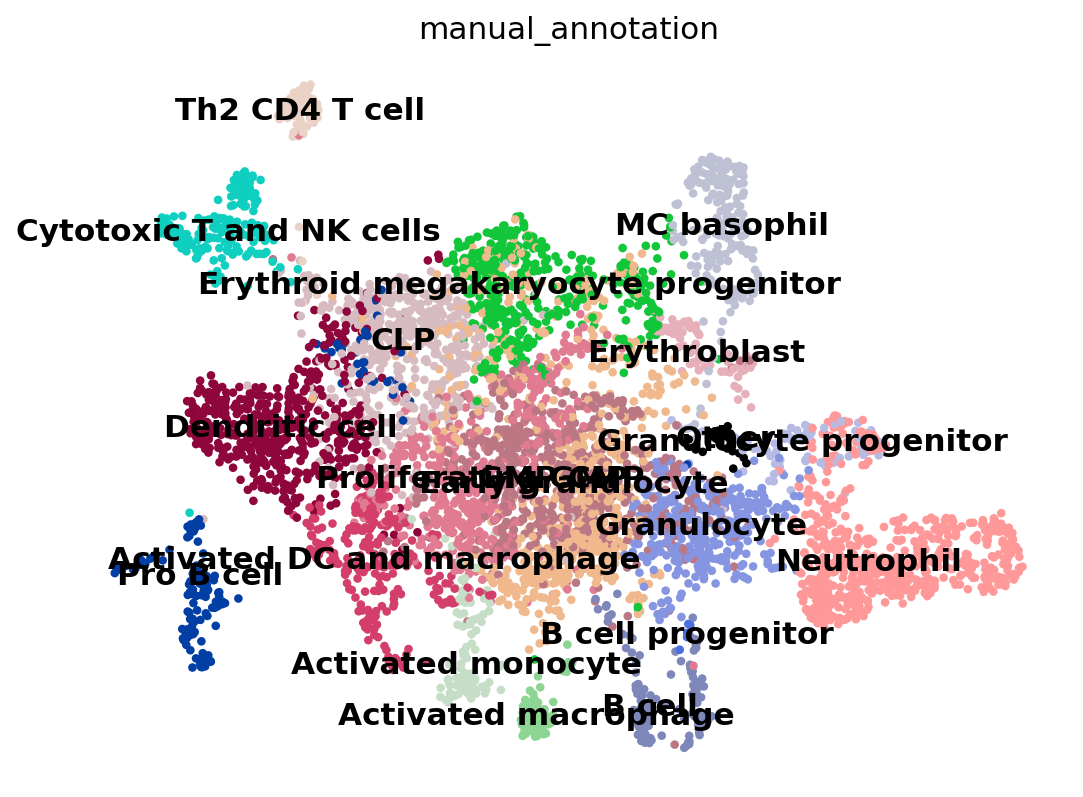

In [48]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['manual_annotation'],
    frameon=False,
    ncols=1,
    legend_loc='on data',
    size = 60,
    palette = color_mapping,
    save = "all_celltypes_X_scVI_reannotated_ondata.pdf"
)

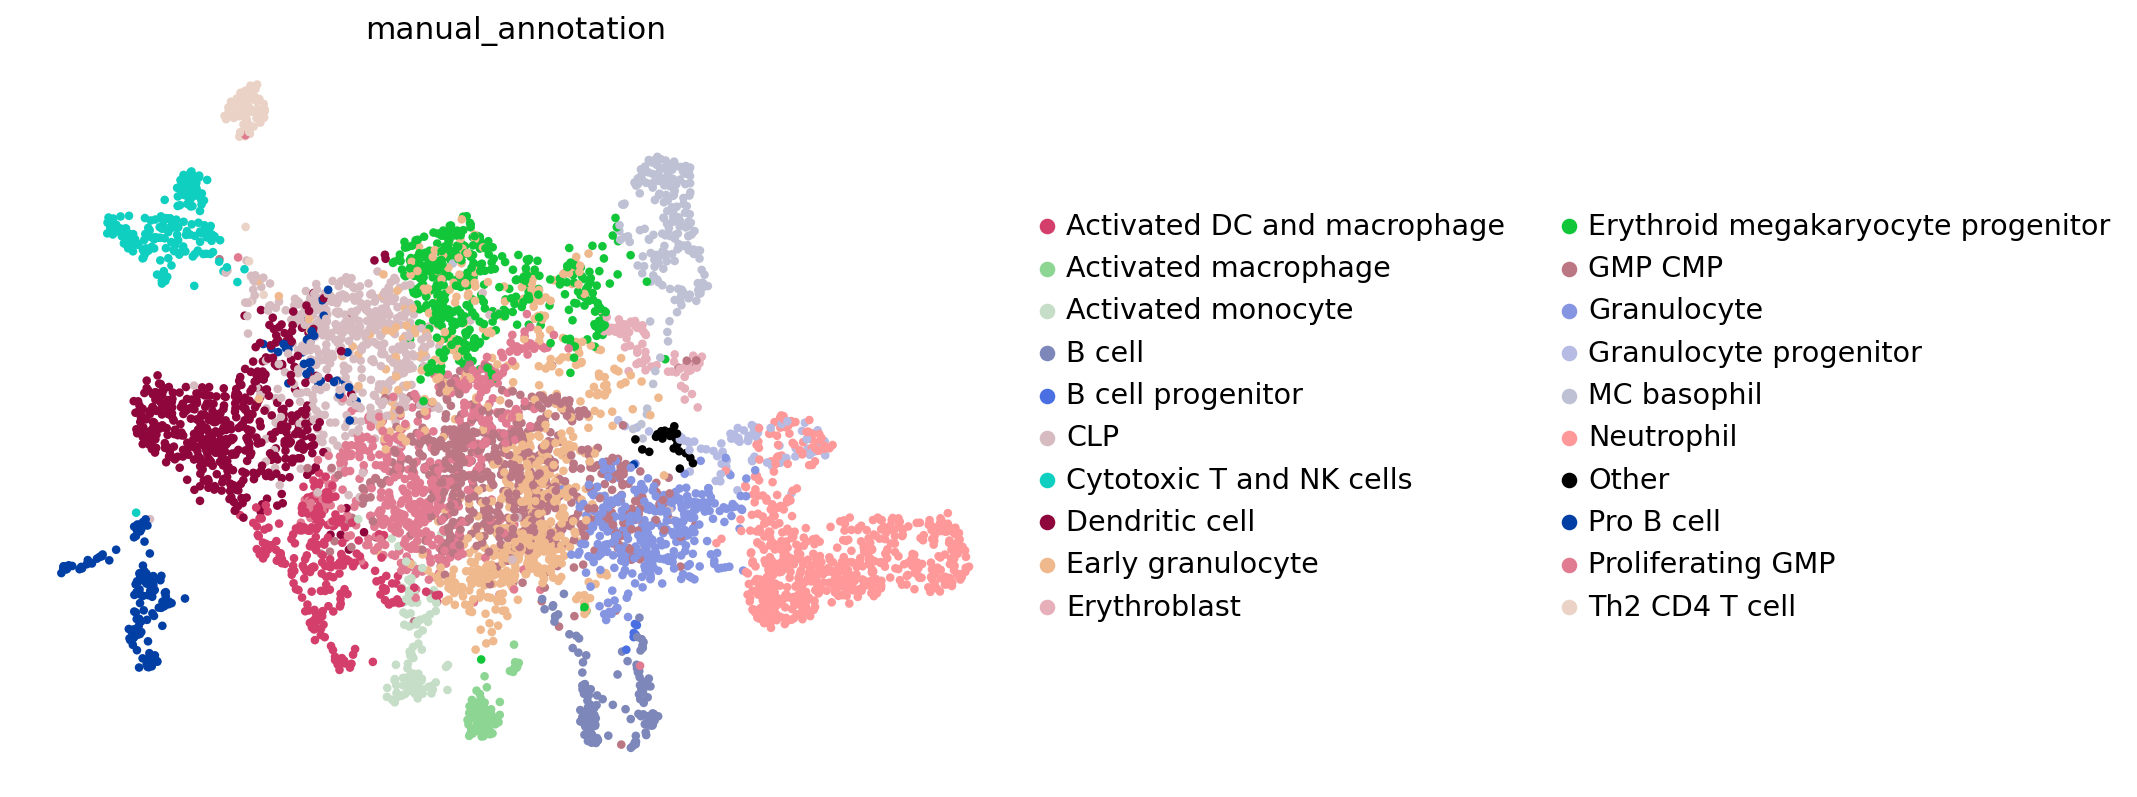

In [49]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['manual_annotation'],
    frameon=False,
    ncols=1,
    # legend_loc='on data',
    size = 60,
    palette = color_mapping,
    save = "all_celltypes_X_scVI_reannotated_legend_right.pdf"
)

In [135]:
hvg_subset.obs

nCount_RNA  nFeature_RNA    sample  nCount_HTO  \
AAACGAACACAATGCT-1     10813.0          3392   HTO-SA3       218.0   
AAACGCTTCTCCTGTG-1      9923.0          2013   HTO-SA4       306.0   
AAAGAACCACTACACA-1       579.0           337  HTO-PBS4       199.0   
AAAGAACCAGCCGTCA-1       681.0           418   HTO-SA3        79.0   
AAAGGATGTAGCTAAA-1      1930.0          1011   HTO-SA3       157.0   
...                        ...           ...       ...         ...   
TTTGGTTCAGGTGTGA-1      3363.0          1269  HTO-PBS2       511.0   
TTTGGTTTCAAGTAAG-1      3192.0          1349  HTO-PBS1       660.0   
TTTGTTGAGCACGATG-1      1808.0           971  HTO-PBS1       962.0   
TTTGTTGGTCCACTCT-1       558.0           412  HTO-PBS2        69.0   
TTTGTTGGTCCTGGTG-1      1644.0          1035  HTO-PBS2        45.0   

                    nFeature_HTO HTO_maxID HTO_secondID  HTO_margin  \
AAACGAACACAATGCT-1             3   HTO-SA3      HTO-SA4    2.225799   
AAACGCTTCTCCTGTG-1             4   HTO-SA4      HTO-SA3    3.358051   
AAAGAACCACTACACA-1             4  HTO-PBS4     HTO-PBS3    2.674194   
AAAGAACCAGCCGTCA-1             3   HTO-SA3      HTO-SA4    1.796318   
AAAGGATGTAGCTAAA-1             4   HTO-SA3     HTO-PBS3    2.314723   
...                          ...       ...          ...         ...   
TTTGGTTCAGGTGTGA-1             3  HTO-PBS2     HTO-PBS1    3.916576   
TTTGGTTTCAAGTAAG-1             3  HTO-PBS1     HTO-PBS2    2.611459   
TTTGTTGAGCACGATG-1             3  HTO-PBS1     HTO-PBS2    3.615213   
TTTGTTGGTCCACTCT-1             3  HTO-PBS2      HTO-SA1    1.679065   
TTTGTTGGTCCTGGTG-1             3  HTO-PBS2     HTO-PBS1    1.514226   

                   HTO_classification   hash.ID RNA_snn_res.0.6  \
AAACGAACACAATGCT-1            HTO-SA3   HTO-SA3               1   
AAACGCTTCTCCTGTG-1            HTO-SA4   HTO-SA4               3   
AAAGAACCACTACACA-1           HTO-PBS4  HTO-PBS4               4   
AAAGAACCAGCCGTCA-1            HTO-SA3   HTO-SA3               4   
AAAGGATGTAGCTAAA-1            HTO-SA3   HTO-SA3               8   
...                               ...       ...             ...   
TTTGGTTCAGGTGTGA-1           HTO-PBS2  HTO-PBS2               9   
TTTGGTTTCAAGTAAG-1           HTO-PBS1  HTO-PBS1               5   
TTTGTTGAGCACGATG-1           HTO-PBS1  HTO-PBS1               6   
TTTGTTGGTCCACTCT-1           HTO-PBS2  HTO-PBS2               0   
TTTGTTGGTCCTGGTG-1           HTO-PBS2  HTO-PBS2               6   

                   seurat_clusters  percent_mt  nCount_SCT  nFeature_SCT  \
AAACGAACACAATGCT-1               5    2.561731      4739.0          2569   
AAACGCTTCTCCTGTG-1               6    1.310088      5166.0          1539   
AAAGAACCACTACACA-1               4   30.224525      3178.0           849   
AAAGAACCAGCCGTCA-1               9    4.405286      3432.0           803   
AAAGGATGTAGCTAAA-1               7    2.227979      3818.0          1063   
...                            ...         ...         ...           ...   
TTTGGTTCAGGTGTGA-1              10    3.003271      2569.0          1262   
TTTGGTTTCAAGTAAG-1               0    2.286967      2555.0          1340   
TTTGTTGAGCACGATG-1               4    2.544248      1984.0           969   
TTTGTTGGTCCACTCT-1               7    1.075269      1672.0           491   
TTTGTTGGTCCTGGTG-1               4    2.554745      1871.0          1034   

                   SCT_snn_res.0.8 rnaseq_labels immgen_labels  batch  \
AAACGAACACAATGCT-1               5     Monocytes    Stem cells  final   
AAACGCTTCTCCTGTG-1               6  Granulocytes   Neutrophils  final   
AAAGAACCACTACACA-1               4     Monocytes    Stem cells  final   
AAAGAACCAGCCGTCA-1               9       B cells       B cells  final   
AAAGGATGTAGCTAAA-1               7     Monocytes     Basophils  final   
...                            ...           ...           ...    ...   
TTTGGTTCAGGTGTGA-1              10       B cells       B cells  pilot   
TTTGGTTTCAAGTAAG-1      

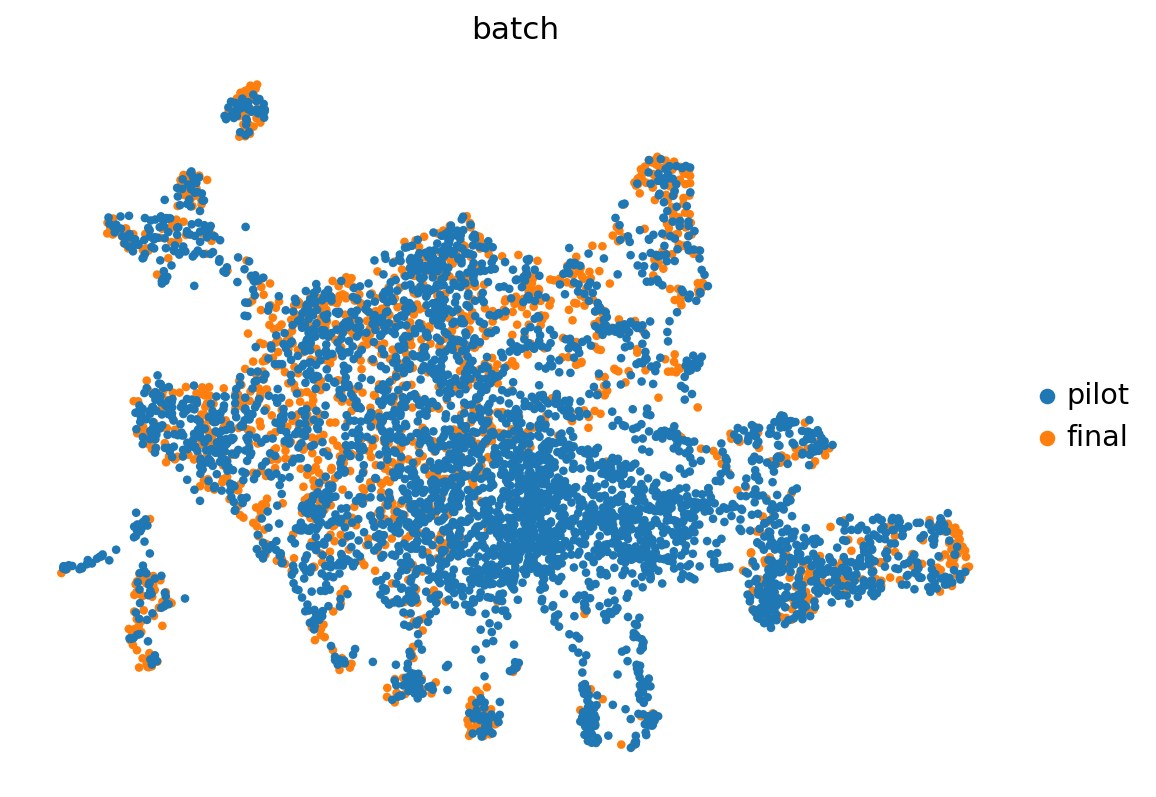

In [148]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['batch'],
    frameon=False,
    ncols=1,
    # legend_loc='on data',
    size = 60,
    save = "all_celltypes_X_scVI_batch_legend_right.pdf"
)

In [143]:
hvg_subset.obs["condition"] = hvg_subset.obs['sample'].apply(lambda x: 'SA' if 'SA' in x else 'PBS')

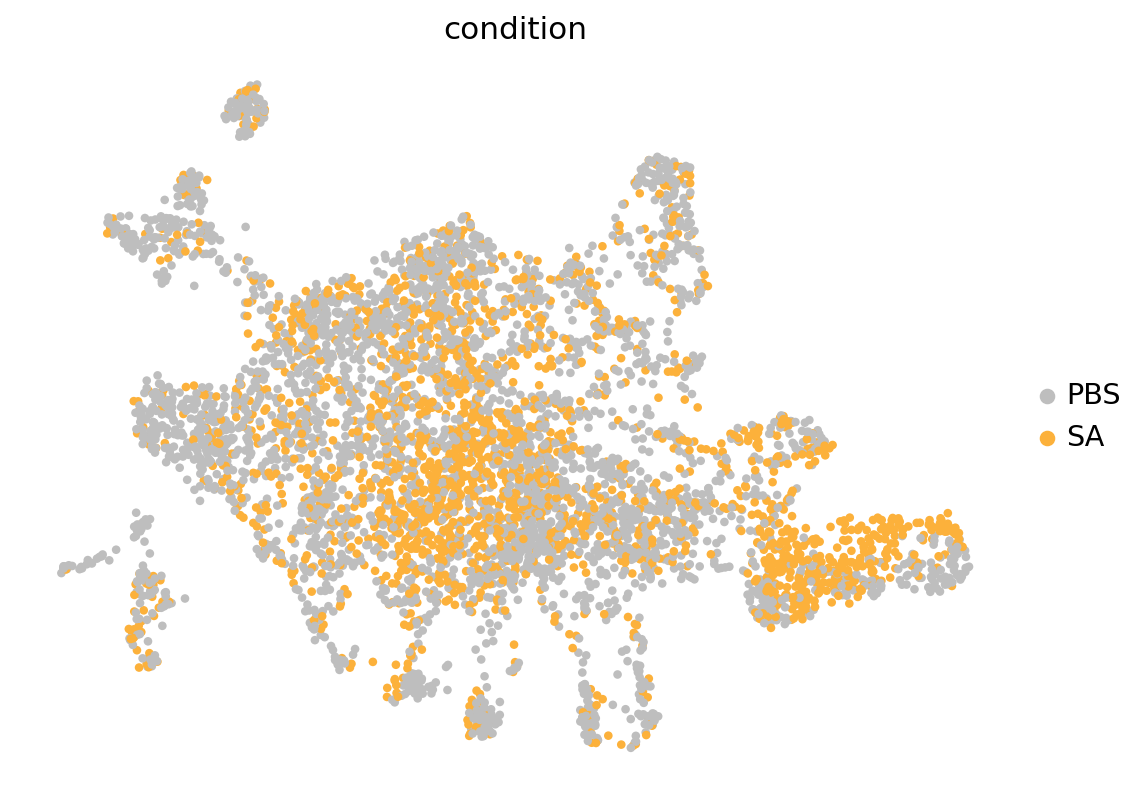

In [152]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=["condition"],
    frameon=False,
    ncols=1,
    # legend_loc='on data',
    size = 60,
    palette = {"PBS": "#BEBEBE", "SA": "#fcb13b"},
    save = "all_celltypes_X_scVI_condition_legend_right.pdf"
)

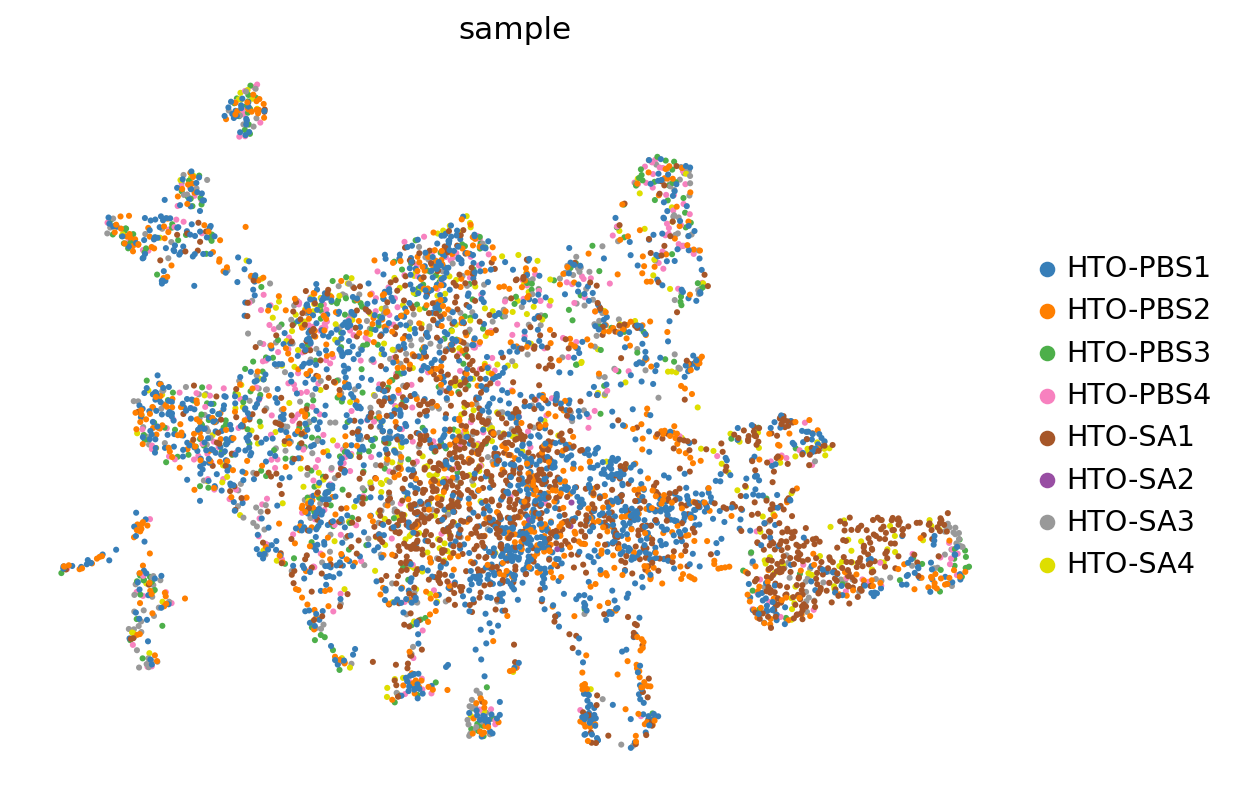

In [57]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=["sample"],
    frameon=False,
    ncols=1,
    # legend_loc='on data',
    size = 30,
    palette = {"HTO-PBS1" : '#377eb8', "HTO-PBS2" : '#ff7f00', "HTO-PBS3" : '#4daf4a',
                  "HTO-PBS4" : '#f781bf', "HTO-SA1" : '#a65628', "HTO-SA2" : '#984ea3',
                  "HTO-SA3" :'#999999',"HTO-SA4" : '#dede00'},
    save = "all_celltypes_X_scVI_sample_legend_right.pdf"
)

### KI67 expression across clusters

In [79]:
hvg_subset.layers
hvg_subset.layers['z_scores'] = (hvg_subset.X - np.mean(hvg_subset.X, axis=0)) / np.std(hvg_subset.X, axis=0)

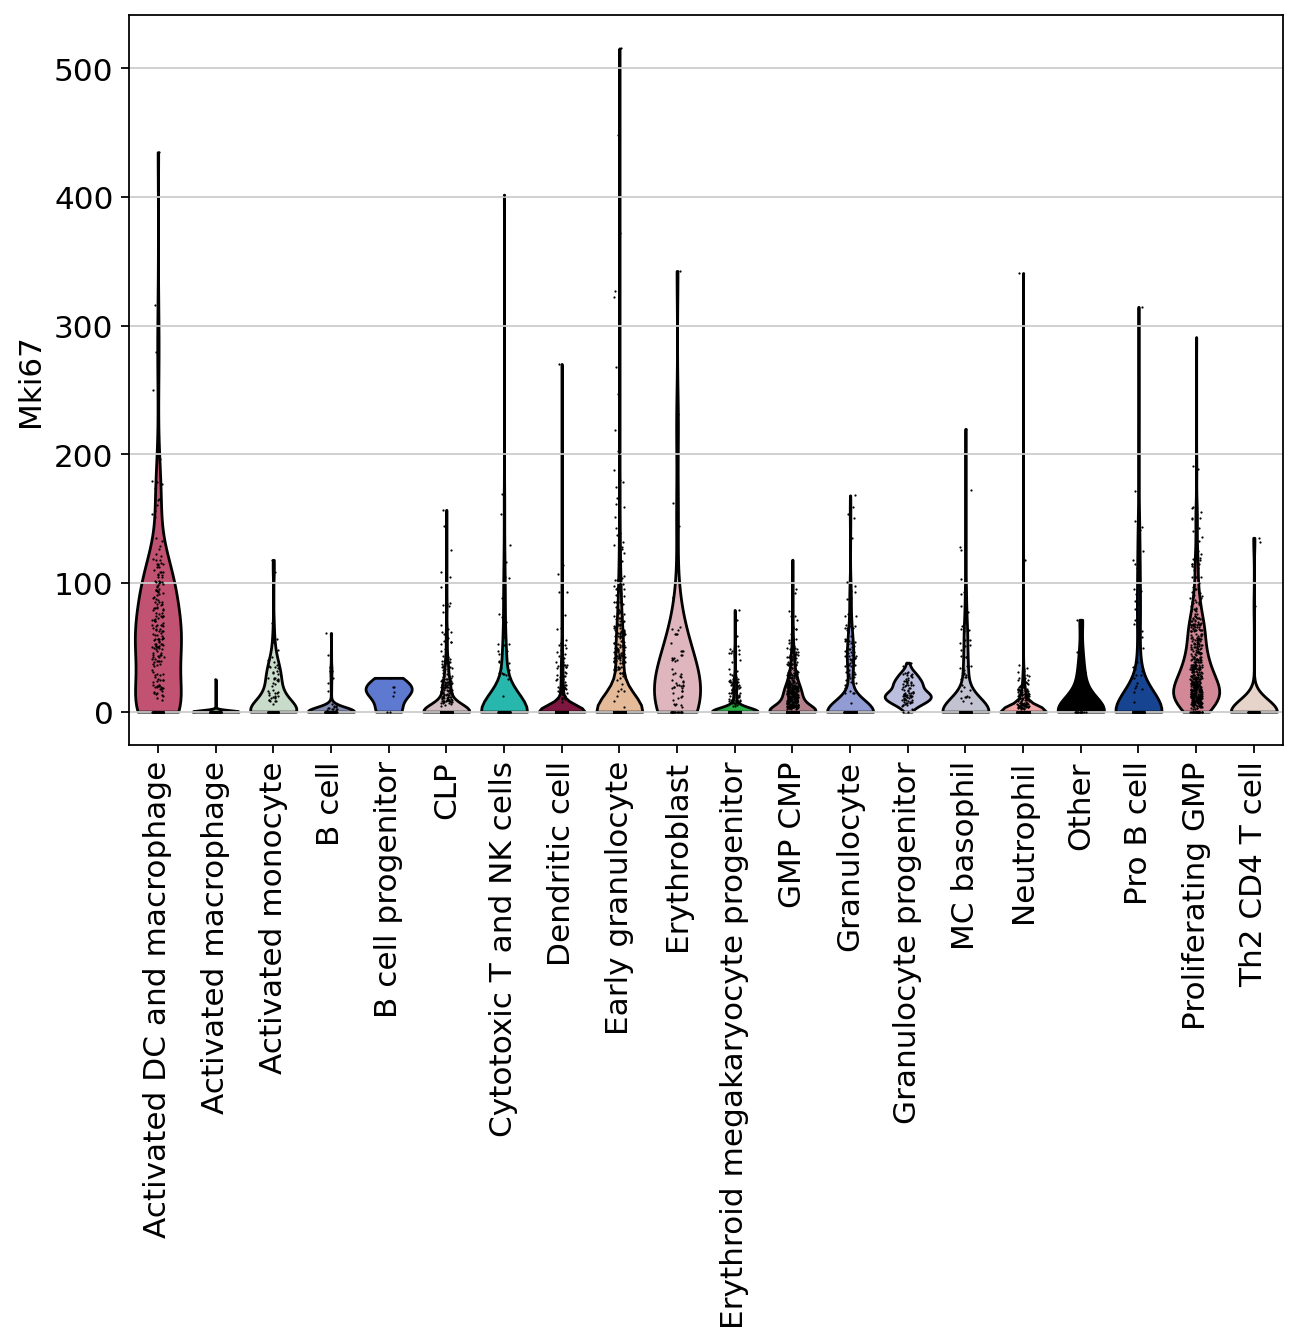

In [98]:
sc.pl.violin(adata=hvg_subset, keys = "Mki67", groupby="manual_annotation", use_raw=True, # layer = "z_scores", 
             rotation = 90,
            save = "KI67_violin_all_cells.pdf")

In [90]:
list(hvg_subset.obs["manual_annotation"].unique())

['Erythroid megakaryocyte progenitor',
 'Erythroblast',
 'Early granulocyte',
 'Pro B cell',
 'MC basophil',
 'Cytotoxic T and NK cells',
 'Proliferating GMP',
 'Dendritic cell',
 'Activated macrophage',
 'GMP CMP',
 'Th2 CD4 T cell',
 'CLP',
 'Neutrophil',
 'Granulocyte progenitor',
 'Activated monocyte',
 'Activated DC and macrophage',
 'B cell',
 'Granulocyte',
 'Other',
 'B cell progenitor']

In [91]:
cell_types_of_interest = ['Early granulocyte', 'Proliferating GMP',"GMP CMP", "Neutrophil", "Granulocyte progenitor", "Activated monocyte", "Granulocyte" ]  # Replace with exact names from your dataset
hvg_subset_granulo_cells = hvg_subset[hvg_subset.obs["manual_annotation"].isin(cell_types_of_interest)]

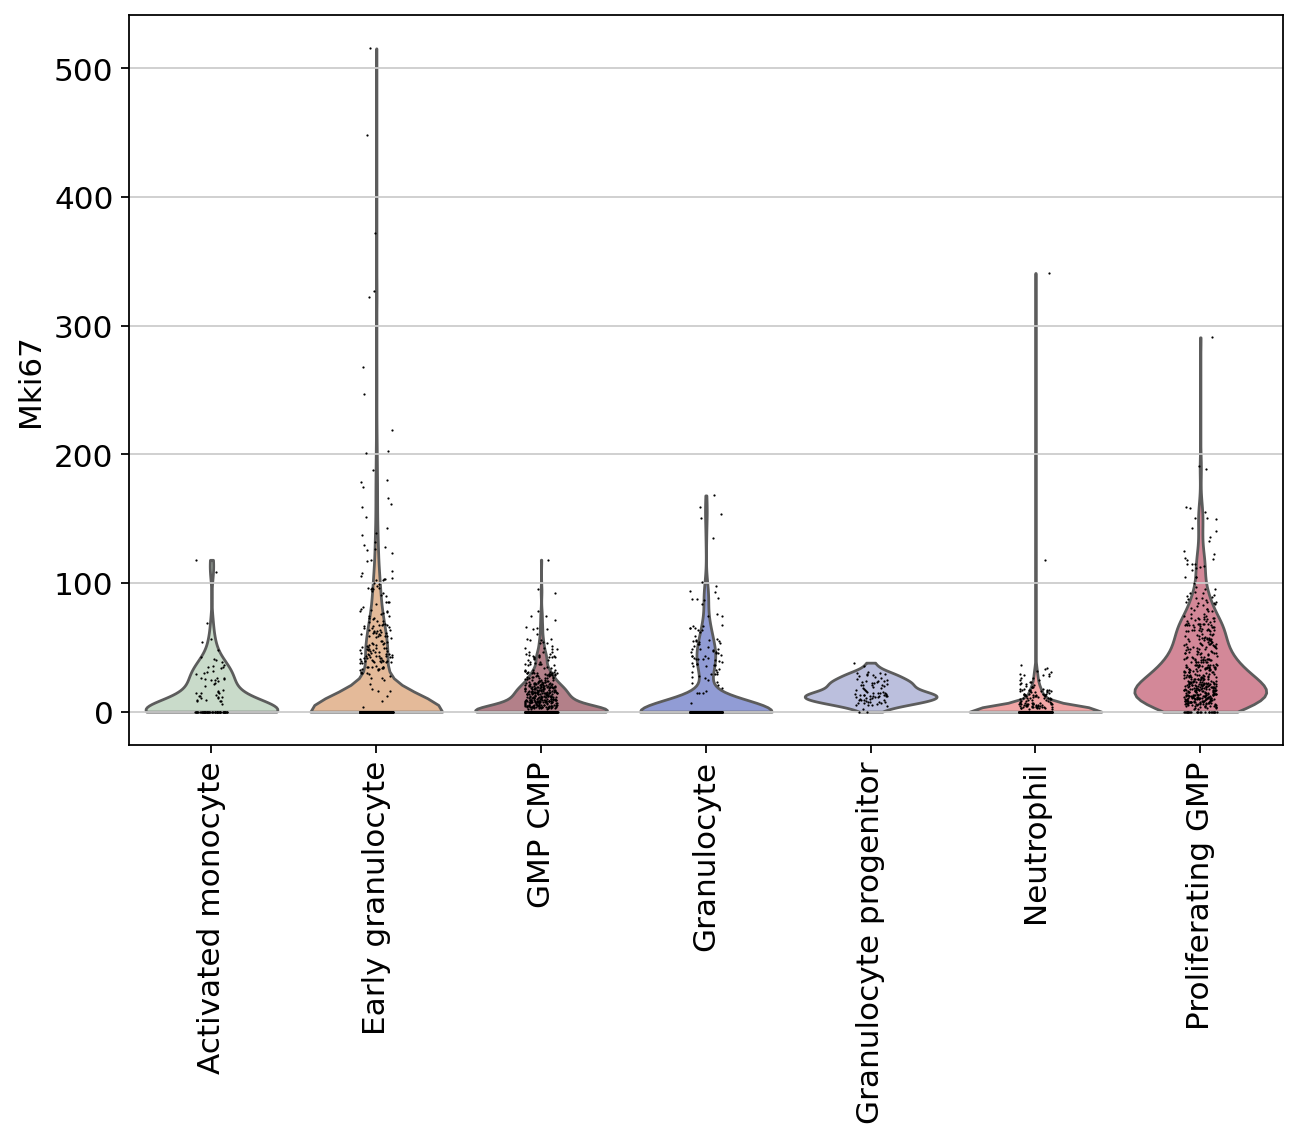

In [99]:
sc.pl.violin(adata=hvg_subset_granulo_cells, keys = "Mki67", groupby="manual_annotation", use_raw=True, # layer = "z_scores", 
             rotation = 90,
            save = "KI67_violin_granulo_cells.pdf")

# Cell cycle info

In [26]:
cell_cycle_h5ad = sc.read_h5ad(filename = "../data/h5ad/hvg_integrated_170824_cell_cycle_phases.h5ad")
# bm_velo.obs_names = bm_velo.obs["obs_names"]
# cell_cycle = bm_velo.obs["cell_cycle_phase"]

In [27]:
cell_cycle_h5ad.obs_names

Index(['AAACCCAAGTCAGGGT-1', 'AAACCCACACAAAGCG-1', 'AAACCCACAGGATTCT-1',
       'AAACCCAGTCTCACGG-1', 'AAACCCAGTTCAGGTT-1', 'AAACCCATCGCATAGT-1',
       'AAACGAAAGAAATGGG-1', 'AAACGAACAAACAGGC-1', 'AAACGAAGTAATGATG-1',
       'AAACGCTAGACCCTTA-1',
       ...
       'TTTGACTCAATCAAGA-1', 'TTTGACTCACAAGTGG-1', 'TTTGACTTCGAGAACG-1',
       'TTTGATCTCAATCGGT-1', 'TTTGGAGAGGAGATAG-1', 'TTTGGAGGTAAGTTAG-1',
       'TTTGGAGTCGATTTCT-1', 'TTTGGTTCAACTGCCG-1', 'TTTGGTTCACAGCGCT-1',
       'TTTGTTGAGTATGGCG-1'],
      dtype='object', length=5517)

In [35]:
hvg_subset.obs["cell_cycle_phase"] = cell_cycle_h5ad[hvg_subset.obs_names].obs["cell_cycle_phase"]

In [36]:
cell_cycle_colors = {
    "G1-S":"#7d87b9", 
    "G2-M" : "#e07b91",
    "M": "#0fcfc0", 
    "M-G1": "#c6dec7", 
    "S": "#d33f6a"}

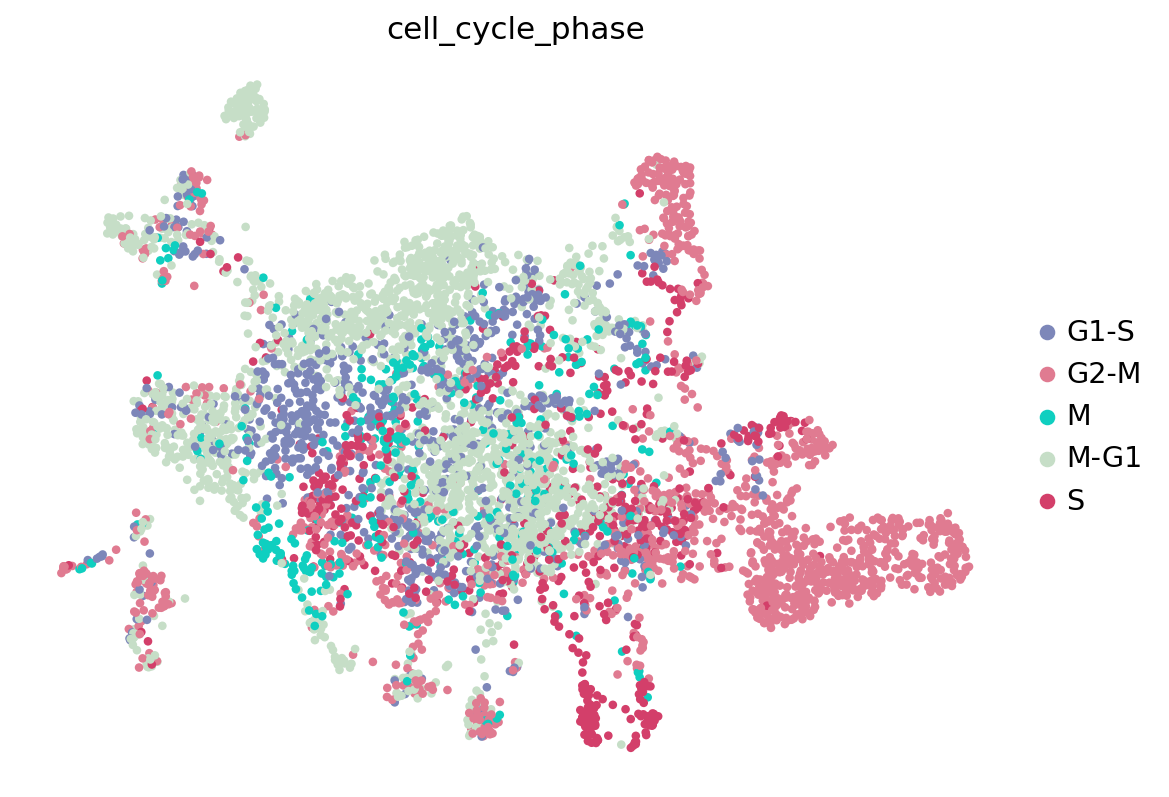

In [38]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['cell_cycle_phase'],
    frameon=False,
    ncols=1,
    # legend_loc='on data',
    size = 60,
    palette = cell_cycle_colors,
    save = "all_celltypes_X_scVI_cell_cycle.pdf")